<a href="https://colab.research.google.com/github/fdeloscogna/Python_experiment/blob/main/Tesi_Python_NORMAL_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
##################################################
# Imports and setting the seed
##################################################

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight
from torch.utils.data import DataLoader,Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.models import Model
from torchvision import models,transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import time

import matplotlib.pyplot as plt

import seaborn as sns

import random
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
##################################################
# Setting the device and check if GPU is available
##################################################
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

GPU enabled!


In [3]:
##################################################
# Data import from the Drive
##################################################
image_directory = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification'
labels_file_path = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification/labels.csv'
labeled_data = pd.read_csv(labels_file_path)
'''
Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.
Get the labeled image filenames and their corresponding labels
'''
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1

# Dataset pre-processing section:

In [4]:
##################################################
# Data pre-processing section
##################################################
class CustomDataset(Dataset):
    def __init__(self, image_directory, labels_file_path, transform=None, provided_filenames=None, provided_labels=None):
        """
        CustomDataset


        section.
        Parameters considered in the function:
        - transform which is an optional transform to be applied to the images.
        - provided_filenames which represent the list of filenames corresponding to the images.
        - provided_labels that correspornd to the list of labels corresponding to the images.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labels_file_path)
        self.transform = transform

        # Use provided filenames and labels if available
        if provided_filenames is not None and provided_labels is not None:
            self.filenames = provided_filenames
            self.labels = provided_labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        Function to get the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.
        Parameters:
        - idx (int): Index of the item to retrieve.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        #Since, from literature, many machine learning models and expect images to be in RGB format such as VGG16.
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        #It return here a tuble with the image and its label
        return image, label

In [5]:
##################################################
# Image dimension setting
##################################################
max_width = 0
max_height = 0
#Store the image's dimensions info
for file_name in labeled_filenames:
    file_path = os.path.join(image_directory, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)

In [6]:
##################################################
# Basic transformation maintaining original data
##################################################

transform_basic = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


'''
Transformation section is not conducted since the operations applyied is just resizing the images to the maximum width and heigh updated,
then converts them to tensors, and applies normalization to be recognized by algorithms.
Unlike the other notebook all the augmented part is not considered
'''

dataset_basic = CustomDataset(image_directory, labels_file_path, transform = transform_basic)
stacked_dataset = ConcatDataset([dataset_basic])
stacked_labels = np.concatenate([labels])


##################################################
# Stratified K fold to improve wighting of dataset
##################################################

k_folds = 8
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

'''
Create an instance of stratified k-fold cross-validation.
As seen from theory it splits the data into k folds while preserving the class distribution.
The shuffle parameter is set to True to shuffle the data before splitting,
and the random_state is considered for reproducibility.
'''

for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the fold considered
    train_data = [dataset_basic[idx] for idx in train_index]
    val_data = [dataset_basic[idx] for idx in val_index]


    # Calculate class weights
    weights_of_classes = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    '''
    Compute the class weights by taking the reciprocal of the counts of each class in the training set.
    This gives more weight to underrepresented classes and less weight to overrepresented classes.
    '''
    train_class_weights = weights_of_classes[stacked_labels[train_index]]
    # Extract the class weights corresponding to the training labels.

    # Weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)
    '''
    Create a WeightedRandomSampler, which samples elements from the training data with replacement
    according to the specified class weights. This oversamples the underrepresented classes
    during training to balance the class distribution.
    '''
    # Data loader
    batch_size = 6
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    # Create a DataLoader for the training data, using the WeightedRandomSampler to sample batches.
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Create a DataLoader for the validation data without sampling, shuffling the data within each

Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


# Models and experiment with epochs

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - ResNet50 Training Loss: 1.1450
Epoch 2/15 - ResNet50 Training Loss: 1.0319
Epoch 3/15 - ResNet50 Training Loss: 1.0705
Epoch 4/15 - ResNet50 Training Loss: 0.9600
Epoch 5/15 - ResNet50 Training Loss: 0.9569
Epoch 6/15 - ResNet50 Training Loss: 1.1802
Epoch 7/15 - ResNet50 Training Loss: 0.8875
Epoch 8/15 - ResNet50 Training Loss: 0.7698
Epoch 9/15 - ResNet50 Training Loss: 1.1587
Epoch 10/15 - ResNet50 Training Loss: 1.1609
Epoch 11/15 - ResNet50 Training Loss: 0.8400
Epoch 12/15 - ResNet50 Training Loss: 0.7482
Epoch 13/15 - ResNet50 Training Loss: 0.7937
Epoch 14/15 - ResNet50 Training Loss: 1.0075
Epoch 15/15 - ResNet50 Training Loss: 0.6679
Total Time: 49.21 seconds


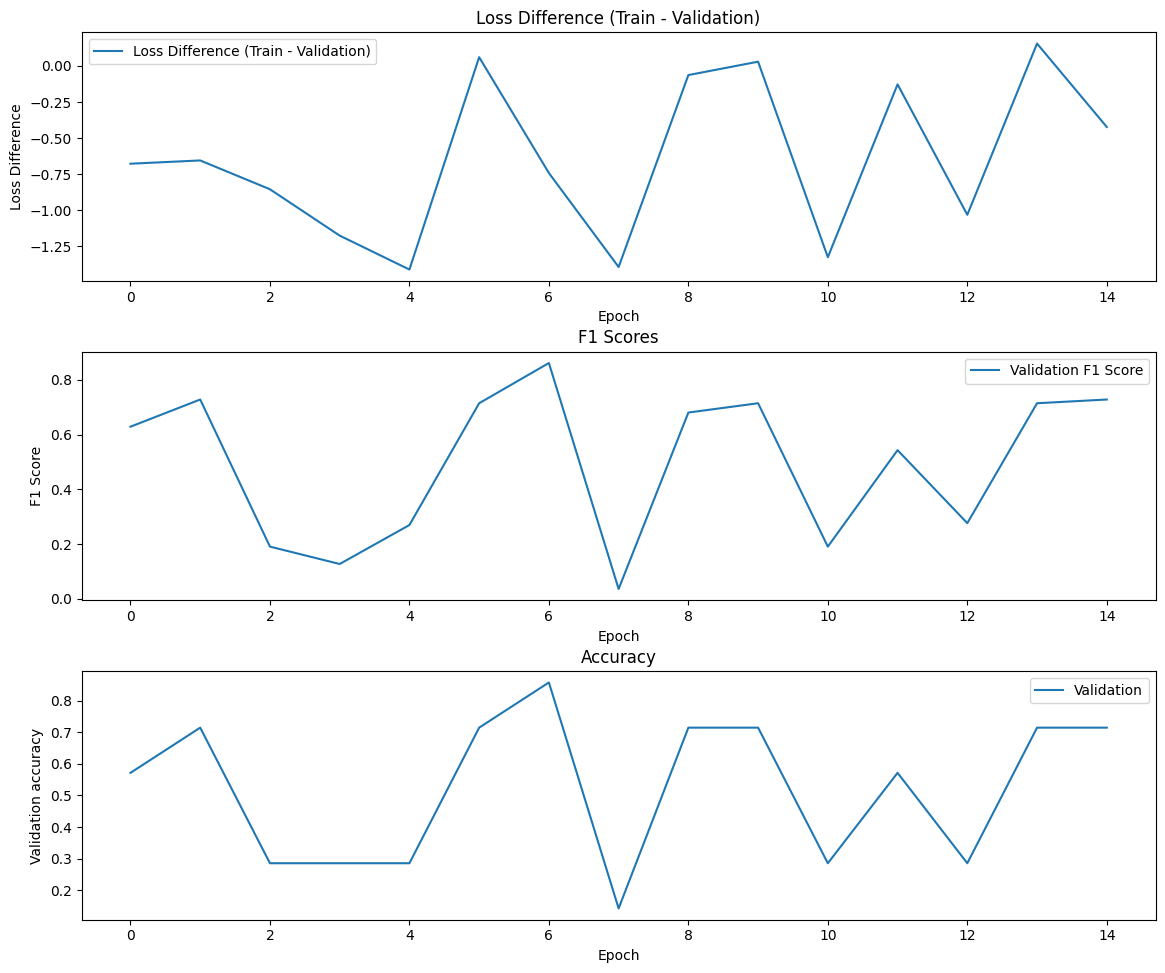

In [ ]:
##################################################
# Resnet 50
##################################################

num_classes = 3  # +1 0 -1
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)  # Modify the output layer

# Move the model to the device (GPU if available)
resnet_model = resnet_model.to(device)

# Define the loss function and optimizer
parameter_loss = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

# Initialize lists to store training and validation metrics
train_losses = []
val_accuracies_pre = []
val_f1_scores_pre = []
val_accuracies = []
val_losses = []
#track_time_pre_append = []

track_time_pre = time.time()

num_epochs = 15
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = parameter_loss(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")


    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = parameter_loss(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to the respective lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    val_loss /= len(val_dataloader)

    val_f1_pre = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_pre = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_pre.append(val_f1_pre)      # actual validation F1 score
    val_accuracies_pre.append(val_accuracy_pre)      # actual validation accuracy

finish_end_time_pre = time.time()

# Calculate the total training time
total_time_pre = finish_end_time_pre - track_time_pre

loss_difference_pre = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=[12, 10])  # Two rows and two columns of subplots
fig.tight_layout(pad=3.0)
# Plot the loss difference
axs[0].plot(loss_difference_pre, label='Loss Difference (Train - Validation)')
axs[0].set_title('Loss Difference (Train - Validation)')
axs[0].set_ylabel('Loss Difference')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training and validation F1 scores
axs[1].plot(val_f1_scores_pre, label='Validation F1 Score')
axs[1].set_title('F1 Scores')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend()

#Accuracy
axs[2].plot(val_accuracies_pre, label='Validation')
axs[2].set_title('Accuracy')
axs[2].set_ylabel('Validation accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend()

print(f"Total Time: {total_time_pre:.2f} seconds")


plt.show()

VGG 16 without augmented dataset

In [ ]:
##################################################
# VGG 16
##################################################

weight = models.VGG16_Weights.DEFAULT
pre_model = models.vgg16(weights = weight)

# Freeze all the parameters of the pretrained models
for param in pre_model.parameters():
    param.requires_grad = False

num_classes = 3
last_item_index = len(pre_model.classifier) - 1
old_fc = pre_model.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features,
                   out_features= num_classes, bias=True)
pre_model.classifier.__setitem__(last_item_index , new_fc)

In [ ]:
pre_model = pre_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(pre_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [ ]:
val_f1_scores_vgg = []
train_accuracies = []
val_accuracies_vgg = []
train_losses = []
val_losses = []  # Initialize an empty list to store validation accuracies

Epoch 1/15 - VGG 16 Training Loss: 1.0450
Epoch 2/15 - VGG 16 Training Loss: 0.8930
Epoch 3/15 - VGG 16 Training Loss: 0.6896
Epoch 4/15 - VGG 16 Training Loss: 0.6845
Epoch 5/15 - VGG 16 Training Loss: 0.7340
Epoch 6/15 - VGG 16 Training Loss: 0.5884
Epoch 7/15 - VGG 16 Training Loss: 0.5848
Epoch 8/15 - VGG 16 Training Loss: 0.7361
Epoch 9/15 - VGG 16 Training Loss: 0.4248
Epoch 10/15 - VGG 16 Training Loss: 0.4862
Epoch 11/15 - VGG 16 Training Loss: 0.4564
Epoch 12/15 - VGG 16 Training Loss: 0.5050
Epoch 13/15 - VGG 16 Training Loss: 0.4458
Epoch 14/15 - VGG 16 Training Loss: 0.3318
Epoch 15/15 - VGG 16 Training Loss: 0.3735
Epoch 15/15 - Validation Loss: 0.5701, F1 Score: 0.7279, Accuracy: 0.7143
Total Time: 91.73 seconds


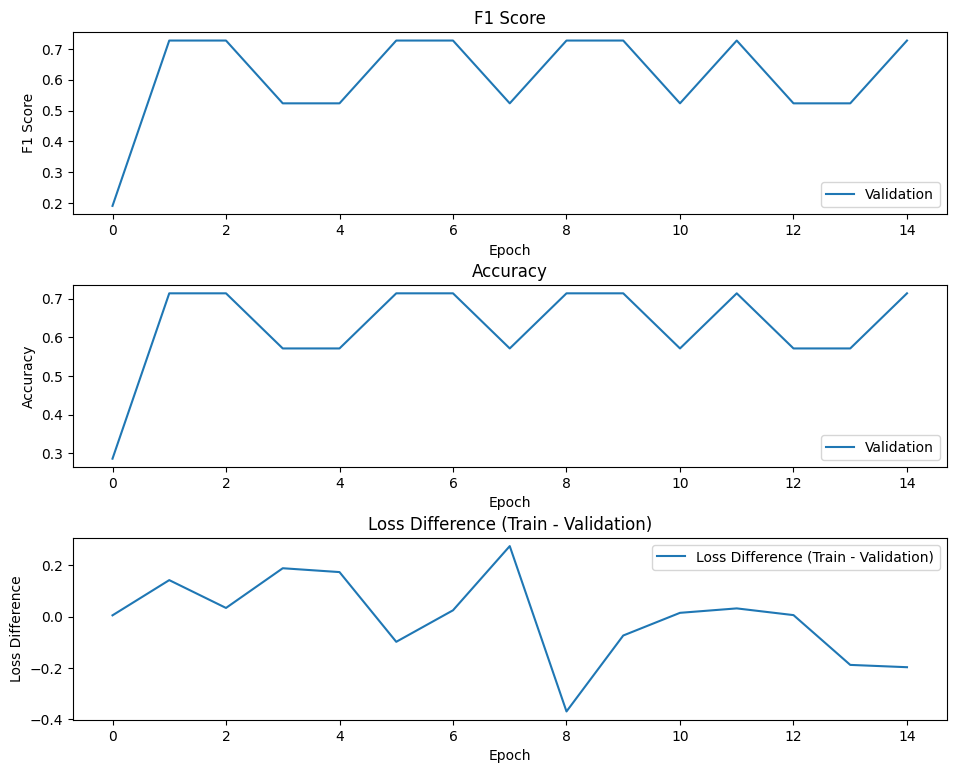

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

track_time_vgg = time.time()

num_epochs = 15
# Set the number of training epochs.
for epoch in range(num_epochs):
    # Training phase for ResNet50
    pre_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
        # Initialize the confusion matrix.
        # Move the images and labels to the specified device (GPU if available).

        optimizer_vgg.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = pre_model(images)
        # Perform a forward pass of the images through the ResNet50 model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_vgg.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - VGG 16 Training Loss: {epoch_loss:.4f}")

    # Print the training loss for the current epoch.
    # Validation phase
    pre_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            premodel_outputs = pre_model(images)
            premodel_loss = parameter_loss(premodel_outputs, labels)

            val_loss += premodel_loss.item()

            _, predictions = torch.max(premodel_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)


            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))
    #print("Confusion Matrix:")
    #print(confusion)

    val_loss /= len(val_dataloader)

    val_f1_vgg = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_vgg = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_vgg.append(val_f1_vgg)
    val_accuracies_vgg.append(val_accuracy_vgg)
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_vgg:.4f}, Accuracy: {val_accuracy_vgg:.4f}")
loss_difference_vgg = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

finish_end_time_vgg = time.time()

# Calculate the total training time
total_time_vgg = finish_end_time_vgg - track_time_vgg

print(f"Total Time: {total_time_vgg:.2f} seconds")


# Plot the loss difference
axs[2].plot(loss_difference_vgg, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_vgg, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_vgg, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

Google Net

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 120MB/s]


Epoch 1/15 - GoogLeNet Training Loss: 0.9858
Epoch 2/15 - GoogLeNet Training Loss: 1.3116
Epoch 3/15 - GoogLeNet Training Loss: 1.0573
Epoch 4/15 - GoogLeNet Training Loss: 1.0724
Epoch 5/15 - GoogLeNet Training Loss: 1.0138
Epoch 6/15 - GoogLeNet Training Loss: 1.0402
Epoch 7/15 - GoogLeNet Training Loss: 1.0580
Epoch 8/15 - GoogLeNet Training Loss: 0.9981
Epoch 9/15 - GoogLeNet Training Loss: 0.9831
Epoch 10/15 - GoogLeNet Training Loss: 0.9162
Epoch 11/15 - GoogLeNet Training Loss: 0.9720
Epoch 12/15 - GoogLeNet Training Loss: 0.9193
Epoch 13/15 - GoogLeNet Training Loss: 0.9934
Epoch 14/15 - GoogLeNet Training Loss: 0.9119
Epoch 15/15 - GoogLeNet Training Loss: 0.8433
Epoch 15/15 - Validation Loss: 0.8452, F1 Score: 0.8612, Accuracy: 0.8571
Total Time: 22.23 seconds


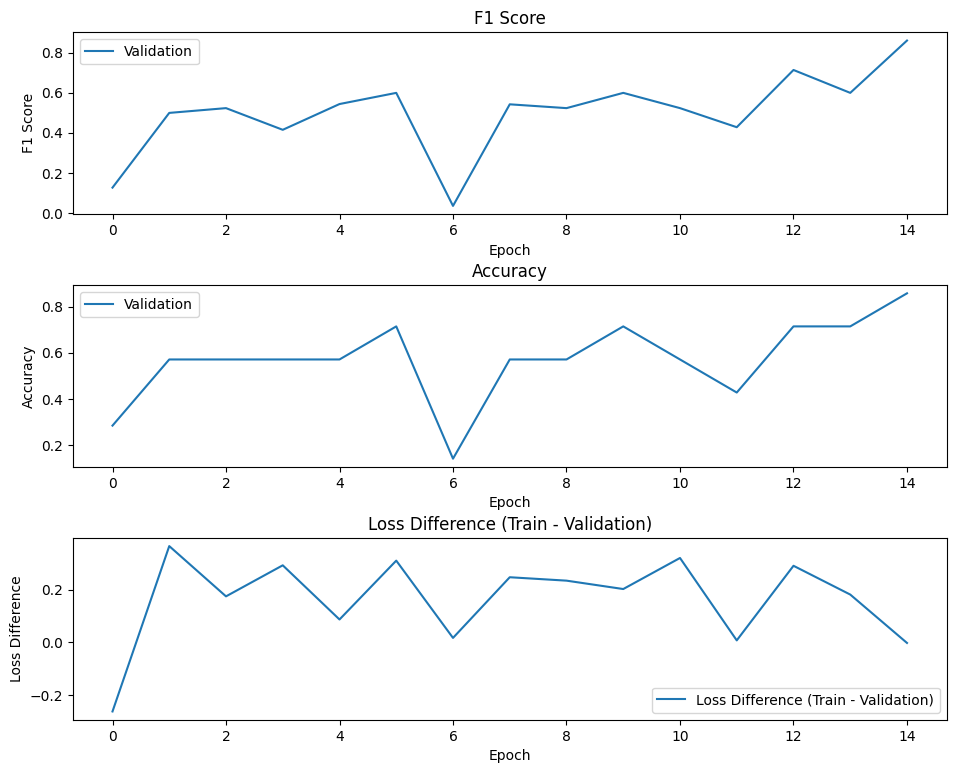

In [ ]:
##################################################
# Google Net
##################################################

fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

# Lists to store training and validation F1 scores and accuracies
val_f1_scores_google = []
train_accuracies = []
val_accuracies_score_google = []
train_losses = []
val_losses = []

pesigoogle = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=pesigoogle)
for param in googlenet_model.parameters():
    param.requires_grad = False
num_classes = 3
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

track_time_google = time.time()
num_epochs = 15
for epoch in range(num_epochs):
    # Training phase for GoogLeNet
    googlenet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation for the gradients of the loss w.r.t the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.

    googlenet_model.eval()

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = parameter_loss(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (googlenet_loss)
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((googlenet_outputs), dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1_google = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy_google = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_google.append(val_f1_google)      # actual validation F1 score
    val_accuracies_score_google.append(val_accuracy_google)      # actual validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_google:.4f}, Accuracy: {val_accuracy_google:.4f}")
finish_end_time_google = time.time()

# Calculate the total training time
total_time_google = finish_end_time_google - track_time_google

print(f"Total Time: {total_time_google:.2f} seconds")

loss_difference_google = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
axs[2].plot(loss_difference_google, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_google, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_score_google, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

# Plot and models evaluation

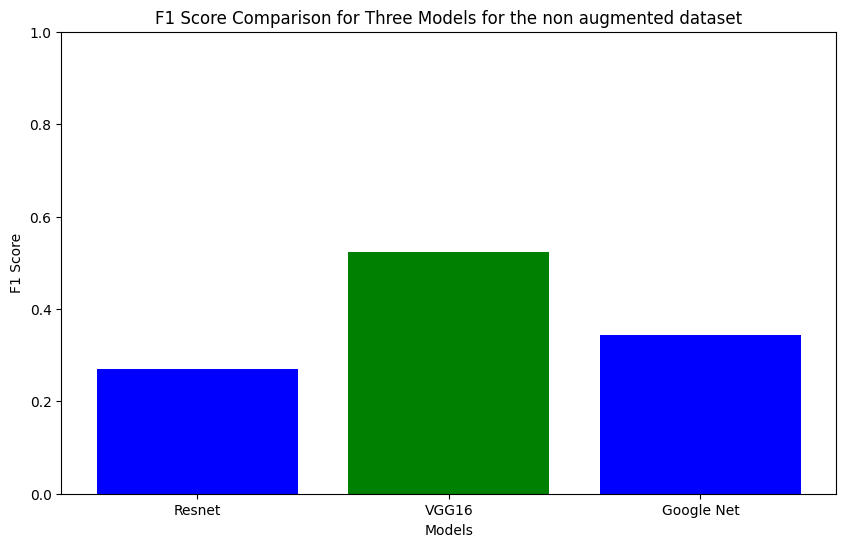

In [ ]:
model_names = ['Resnet', 'VGG16', 'Google Net']
f1_scores = []

f1_scores.append(val_f1_pre)
f1_scores.append(val_f1_vgg)
f1_scores.append(val_f1_google)

best_model_idx = f1_scores.index(max(f1_scores))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Three Models for the non augmented dataset')
plt.ylim(0, 1)
plt.show()

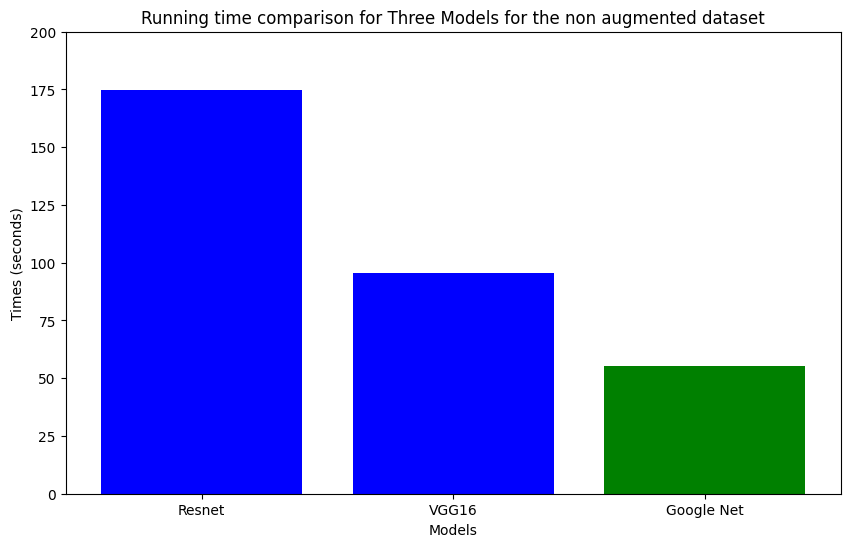

In [ ]:
model_names = ['Resnet', 'VGG16', 'Google Net']
running_times = []

running_times.append(total_time_pre)
running_times.append(total_time_vgg)
running_times.append(total_time_google)

best_model_idx = running_times.index(min(running_times))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, running_times, color=colors)
plt.xlabel('Models')
plt.ylabel('Times (seconds)')
plt.title('Running time comparison for Three Models for the non augmented dataset')
plt.ylim(0, 200)
plt.show()

#Running time section

In [27]:
resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the device
resnet_model = resnet_model.to(device)

#Loss function
parameter_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)


# Lists to store training and validation losses, F1 scores and running time
train_losses = []
val_losses = []
val_accuracies_pre = []
val_f1_scores_pre = []
running_times_pre = []

# Percentages of data to consider
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Store running times and data sizes
data_sizes = []

for percentage in percentages:
    # Calculate the number of elements to consider for the given percentage
    num_elements = len(train_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices = torch.randperm(len(train_data))
    subset_indices = indices[:num_elements]
    subset = torch.utils.data.Subset(train_data, subset_indices)

    # Create a dataloader for the subset
    subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

    # Measure the start time
    start_time = time.time()

#############################################
## Training loop (using subset)
#############################################

    resnet_model.train()
    running_loss = 0.0
    for images, labels in subset_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = parameter_loss(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Percentages of dataset of {percentage} - ResNet50 percentages Loss: {epoch_loss:.4f}")

##############################################
#Validation part with a new subset
#############################################
    num_elements_val = len(val_data) * percentage // 100
    # Shuffle and split the dataset into training and validation subsets
    indices_val = torch.randperm(len(val_data))
    subset_indices_val = indices_val[:num_elements_val]
    subset_val = torch.utils.data.Subset(val_data, subset_indices_val)
    # Create a dataloader for the subset
    subset_dataloader_val = DataLoader(subset_val, batch_size=batch_size)

    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in subset_dataloader_val:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = parameter_loss(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to lists
    train_losses.append(running_loss)
    val_losses.append(val_loss)

    print(f"Percentages of dataset of {percentage} - ResNet50 percentages validation: {val_loss:.4f}")

    val_loss /= len(val_dataloader)

    val_f1_pre = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_pre = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_pre.append(val_f1_pre)

    # Append the running times for this percentage to the main list
    # Measure the end time
    end_time = time.time()

    # Calculate the running time for this percentage
    percentage_running_time = end_time - start_time
    running_times_pre.append(percentage_running_time)

    # Append the running time and corresponding data size to the lists
    data_sizes.append(num_elements)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Percentages of dataset of 10 - ResNet50 percentages Loss: 0.1057
Percentages of dataset of 10 - ResNet50 percentages validation: 0.0000


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Percentages of dataset of 20 - ResNet50 percentages Loss: 0.2796
Percentages of dataset of 20 - ResNet50 percentages validation: 1.4869
Percentages of dataset of 30 - ResNet50 percentages Loss: 0.2989
Percentages of dataset of 30 - ResNet50 percentages validation: 1.1719
Percentages of dataset of 40 - ResNet50 percentages Loss: 0.5632
Percentages of dataset of 40 - ResNet50 percentages validation: 0.3261
Percentages of dataset of 50 - ResNet50 percentages Loss: 0.3599
Percentages of dataset of 50 - ResNet50 percentages validation: 1.1625
Percentages of dataset of 60 - ResNet50 percentages Loss: 0.5859
Percentages of dataset of 60 - ResNet50 percentages validation: 1.0332
Percentages of dataset of 70 - ResNet50 percentages Loss: 0.7060
Percentages of dataset of 70 - ResNet50 percentages validation: 0.6671
Percentages of dataset of 80 - ResNet50 percentages Loss: 0.6691
Percentages of dataset of 80 - ResNet50 percentages validation: 0.7710
Percentages of dataset of 90 - ResNet50 percenta

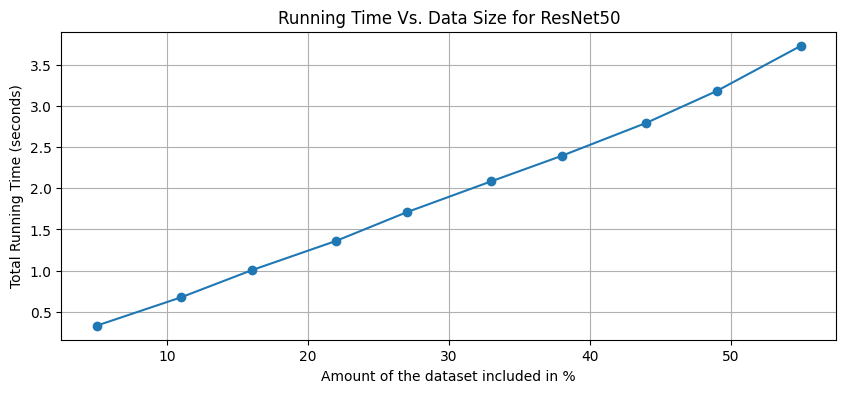

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes, running_times_pre, marker='o', linestyle='-')
plt.title('Running Time Vs. Data Size for ResNet50')
plt.xlabel('Amount of the dataset included in %')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)


plt.show()

In [14]:
weight = models.VGG16_Weights.DEFAULT
vgg_model = models.vgg16(weights = weight)

# Freeze all the parameters of the pretrained models
for param in vgg_model.parameters():
    param.requires_grad = False

num_classes = 3
last_item_index = len(vgg_model.classifier) - 1
old_fc = vgg_model.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features,
                   out_features= num_classes, bias=True)
vgg_model.classifier.__setitem__(last_item_index , new_fc)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.8MB/s]


In [29]:
vgg_model = vgg_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
'''
Compared to the other one the Learning rate here is 0.01
and NOT 0.001 like in the previous experiment with resnet
'''
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)
#optimizer_vgg = optim.SGD(vgg_model.parameters(), lr=0.024, momentum=0.9)

best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [31]:
# Lists to store training and validation F1 scores and accuracies
set_seeds()
val_f1_scores_vgg = []
train_accuracies = []
val_accuracies_vgg = []
train_losses_vgg = []
val_losses_vgg = []
running_times_vgg = []
data_sizes_vgg = []

percentages_vgg = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


for percentage in percentages_vgg:
    num_elements = len(train_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices = torch.randperm(len(train_data))
    subset_indices = indices[:num_elements]
    subset = torch.utils.data.Subset(train_data, subset_indices)

    # Create a dataloader for the subset
    subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle = True)

    # Measure the start time
    track_time_vgg = time.time()

##############################################
#Training phase for VGG16
#############################################

    vgg_model.train()

    # Set the model to train mode.
    running_loss_vgg = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in subset_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_vgg.zero_grad()
        # Clear the gradients from the previous iteration.
        outputs = vgg_model(images)
        # Perform a forward pass of the images through the VGG16 model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_vgg.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss_vgg += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss_vgg = running_loss_vgg / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Percentages of dataset of {percentage} - VGG 16 Training Loss: {epoch_loss_vgg:.4f}")

##############################################
#Validation phase for VGG16
#############################################

    num_elements_val = len(val_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices_val = torch.randperm(len(val_data))
    subset_indices_val = indices_val[:num_elements_val]
    subset_val = torch.utils.data.Subset(val_data, subset_indices_val)
    # Create a dataloader for the subset
    subset_dataloader_val = DataLoader(subset_val, batch_size=batch_size)

    vgg_model.eval()
    val_loss_v = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in subset_dataloader_val:
            images = images.to(device)
            labels = labels.to(device)

            vgg_outputs = vgg_model(images)
            vgg_model_loss = parameter_loss(vgg_outputs, labels)

            val_loss_v += vgg_model_loss.item()

            _, predictions = torch.max(vgg_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    val_loss_v /= len(val_dataloader)
    val_losses_vgg.append(val_loss_v)

    val_f1_vgg = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_vgg = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies
    val_f1_scores_vgg.append(val_f1_vgg)      # actual validation F1 score
    train_losses_vgg.append(epoch_loss_vgg)

    print(f"Percentages of dataset of  {percentage} - Validation Loss: {val_loss_v:.4f}")

    finish_end_time_vgg = time.time()

    # Calculate the running time for this percentage
    total_time_vgg = finish_end_time_vgg - track_time_vgg
    # Append the running time and corresponding data size to the lists
    running_times_vgg.append(total_time_vgg)
    data_sizes_vgg.append(num_elements)


#loss_difference_vgg = [epoch_loss_vgg - val_loss_v for train_loss, val_loss_v in zip(train_losses_vgg, val_losses_vgg)]

Percentages of dataset of 10 - VGG 16 Training Loss: 0.0046
Percentages of dataset of  10 - Validation Loss: 0.0000


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Percentages of dataset of 20 - VGG 16 Training Loss: 0.0413
Percentages of dataset of  20 - Validation Loss: 0.4194
Percentages of dataset of 30 - VGG 16 Training Loss: 0.0607
Percentages of dataset of  30 - Validation Loss: 0.1772
Percentages of dataset of 40 - VGG 16 Training Loss: 0.1054
Percentages of dataset of  40 - Validation Loss: 0.1554
Percentages of dataset of 50 - VGG 16 Training Loss: 0.1023
Percentages of dataset of  50 - Validation Loss: 0.2046
Percentages of dataset of 60 - VGG 16 Training Loss: 0.1195
Percentages of dataset of  60 - Validation Loss: 0.0958
Percentages of dataset of 70 - VGG 16 Training Loss: 0.1257
Percentages of dataset of  70 - Validation Loss: 0.4864
Percentages of dataset of 80 - VGG 16 Training Loss: 0.1716
Percentages of dataset of  80 - Validation Loss: 0.2551
Percentages of dataset of 90 - VGG 16 Training Loss: 0.2146
Percentages of dataset of  90 - Validation Loss: 0.3856
Percentages of dataset of 100 - VGG 16 Training Loss: 0.2279
Percentages

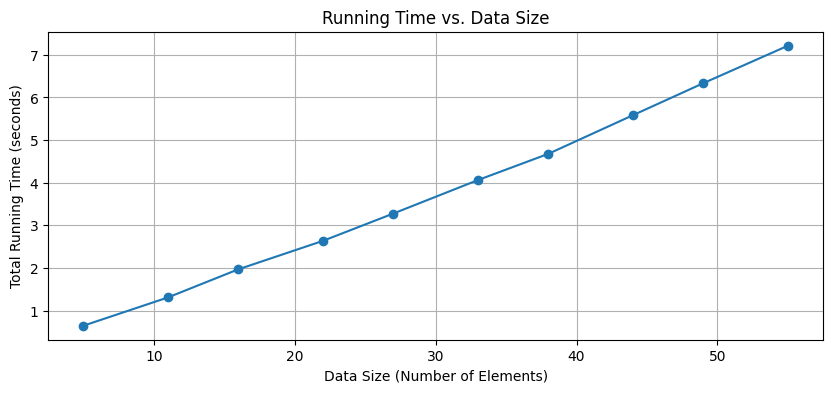

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(data_sizes_vgg, running_times_vgg, marker='o', linestyle='-')
plt.title('Running Time vs. Data Size')
plt.xlabel('Data Size (Number of Elements)')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)

plt.show()

Google Net

In [25]:
# Lists to store training and validation F1 scores and accuracies
val_f1_scores_google = []
train_accuracies = []
val_accuracies_score_google = []
train_losses = []
val_losses = []
data_sizes_google = []
running_times_google = []


pesigoogle = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=pesigoogle)
num_classes = 3
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)
parameter_loss = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.0001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [26]:
percentages_google = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for percentage in percentages_google:
    num_elements = len(train_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices = torch.randperm(len(train_data))
    subset_indices = indices[:num_elements]
    subset = torch.utils.data.Subset(train_data, subset_indices)

    # Create a dataloader for the subset
    subset_dataloader = DataLoader(subset, batch_size=batch_size)


    track_time_google = time.time()

#############################################
#Training phase for GoogLeNet
#############################################

    googlenet_model.train()
    running_loss = 0.0
    # Initialize the running loss for the current amount of dataset considered.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU when available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = parameter_loss(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Percentages of dataset of  {percentage} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.


    num_elements_val = len(val_data) * percentage // 100

    # Shuffle and split the dataset into training and validation subsets
    indices_val = torch.randperm(len(val_data))
    subset_indices_val = indices_val[:num_elements_val]
    subset_val = torch.utils.data.Subset(val_data, subset_indices_val)
    # Create a dataloader for the subset
    subset_dataloader_val = DataLoader(subset_val, batch_size=batch_size)

#############################################
#Validation phase for GoogLeNet
#############################################

    googlenet_model.eval()

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in subset_dataloader_val:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = parameter_loss(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (googlenet_loss)
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((googlenet_outputs), dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1_google = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy_google = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    print(f"Percentages of dataset of {percentage} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_google:.4f}, Accuracy: {val_accuracy_google:.4f}")
    #print("Confusion Matrix:")
    #print(confusion)
    # Print the validation loss, F1 score, and accuracy for the current epoch.

    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_google.append(val_f1_google)      # validation F1 score
    val_accuracies_score_google.append(val_accuracy_google)      # validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    finish_end_time_google = time.time()
    total_time_google = finish_end_time_google - track_time_google


    running_times_google.append(total_time_google)
    data_sizes_google.append(num_elements)


#loss_difference_google = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

'''
finish_end_time_google = time.time()

# Calculate the total training time
total_time_google = finish_end_time_google - track_time_google
print(total_time_google)
'''

Percentages of dataset of  10 - GoogLeNet Training Loss: 1.0500
Percentages of dataset of 10 - Validation Loss: 0.0000, F1 Score: 0.0000, Accuracy: nan


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Percentages of dataset of  20 - GoogLeNet Training Loss: 0.9206
Percentages of dataset of 20 - Validation Loss: 0.7455, F1 Score: 0.0000, Accuracy: 0.0000
Percentages of dataset of  30 - GoogLeNet Training Loss: 0.7707
Percentages of dataset of 30 - Validation Loss: 0.2897, F1 Score: 1.0000, Accuracy: 1.0000
Percentages of dataset of  40 - GoogLeNet Training Loss: 0.7658
Percentages of dataset of 40 - Validation Loss: 0.5151, F1 Score: 0.0000, Accuracy: 0.0000
Percentages of dataset of  50 - GoogLeNet Training Loss: 0.5666
Percentages of dataset of 50 - Validation Loss: 0.3830, F1 Score: 0.5556, Accuracy: 0.6667
Percentages of dataset of  60 - GoogLeNet Training Loss: 0.4752
Percentages of dataset of 60 - Validation Loss: 0.4193, F1 Score: 0.6667, Accuracy: 0.7500
Percentages of dataset of  70 - GoogLeNet Training Loss: 0.5146
Percentages of dataset of 70 - Validation Loss: 0.3121, F1 Score: 0.5000, Accuracy: 0.5000
Percentages of dataset of  80 - GoogLeNet Training Loss: 0.4431
Percen

'\nfinish_end_time_google = time.time()\n\n# Calculate the total training time\ntotal_time_google = finish_end_time_google - track_time_google\nprint(total_time_google)\n'

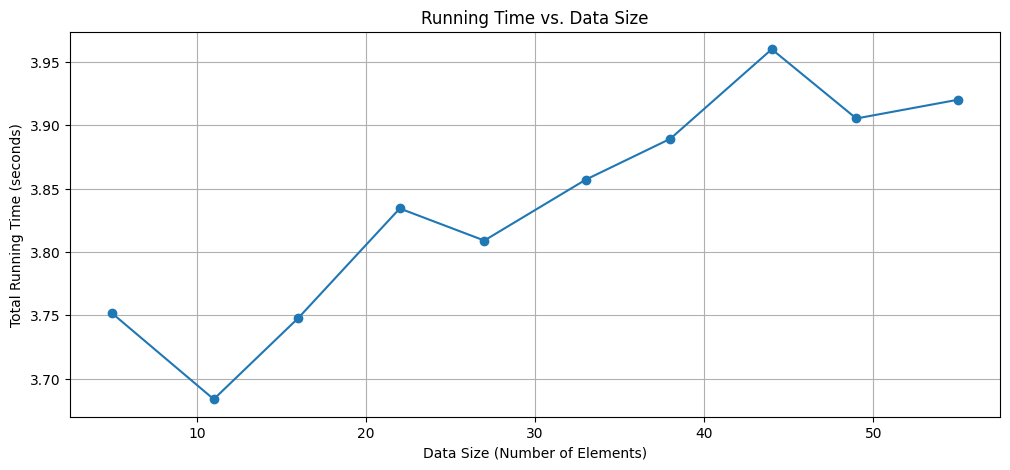

In [32]:
# Now, let's create a plot with the running times vs. data sizes
plt.figure(figsize=(12, 5))
plt.plot(data_sizes_google, running_times_google, marker='o', linestyle='-')
plt.title('Running Time vs. Data Size')
plt.xlabel('Data Size (Number of Elements)')
plt.ylabel('Total Running Time (seconds)')
plt.grid(True)

# Show or save the plot as needed
plt.show()